In [7]:
import os
import sys
import requests
import datetime
import pandas as pd
import numpy as np
import torch, torchvision, torchaudio
import pytorch_lightning as pl
import wandb
import json
import copy
import shutil

import matplotlib.pyplot as plt
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from transformers import DetrConfig, AutoModelForObjectDetection
from transformers import DeformableDetrConfig, DeformableDetrImageProcessor
from transformers import AutoFeatureExtractor
from pytorch_lightning import Trainer
from PIL import Image, ImageDraw

In [8]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, image_name):
        ann_file = os.path.join(img_folder, image_name)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target
    
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Train and Validation Dataset
  #Minimal Dataset
# train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train', processor=processor, image_name="coco_train.json")
# val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val', processor=processor, image_name="coco_val.json")

  #Maximal Dataset
train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train_max', feature_extractor=feature_extractor, image_name="coco_train_max.json")
val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val_max', feature_extractor=feature_extractor, image_name="coco_val_max.json")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))



loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 859
Number of validation examples: 215


c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [9]:
class Detr(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.save_hyperparameters()
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [10]:
# Training




# login to weights and biases, to relogin: wandb.login(key="YOUR KEY", relogin=True)
wandb.login()

date = datetime.datetime.now()
run_name = "Run at the {}".format(date)

lr = 2.5e-5
weight_decay=1e-4

project = "BAA_Book_Damage_Detection"

wandb.init(
    project=project,
    name=run_name,
    config={"learning_rate_transformer": lr,
            "weight_decay": weight_decay,
            "architecture": "YOLOForObjectDetection",
            "dataset": "AllData",
            "train_set_size": len(train_dataset)}
    )

model = Detr(lr=lr, weight_decay=weight_decay)

model.to(device)

# outputs = model(pixel_values=batch['pixel_values'].to(device), pixel_mask=batch['pixel_mask'].to(device))
# print(outputs.logits.shape)

max_steps_var = 2000

wandb_logger = WandbLogger("YOLOForObjectDetection", "../models/", project=project, log_model=True, checkpoint_name=f"YOLOForObjectDetection_{max_steps_var}_Steps")
trainer = Trainer(max_steps=max_steps_var, gradient_clip_val=0.1, accumulate_grad_batches=4, logger=wandb_logger)
trainer.fit(model)

wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([11]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([11, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiati

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=2000` reached.


In [11]:
# load the checkpoint

run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/YOLOForObjectDetection_2000_Steps:v1', type='model')
artifact_dir = artifact.download()

model = Detr.load_from_checkpoint(artifact_dir + "/model.ckpt")

wandb: Downloading large artifact YOLOForObjectDetection_2000_Steps:v1, 351.06MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([11]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([11, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Detr(
  (model): YolosForObjectDetection(
    (vit): YolosModel(
      (embeddings): YolosEmbeddings(
        (patch_embeddings): YolosPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (interpolation): InterpolateInitialPositionEmbeddings()
      )
      (encoder): YolosEncoder(
        (layer): ModuleList(
          (0-11): 12 x YolosLayer(
            (attention): YolosAttention(
              (attention): YolosSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): YolosSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropo

In [15]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

# initialize evaluator with ground truth (gt)
coco_evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(res)
    coco_evaluator.update(predictions)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


  0%|          | 0/215 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

{'scores': tensor([0.6698, 0.6685, 0.6025, 0.6282, 0.6853, 0.6621, 0.7327, 0.6018, 0.6569,
        0.6762, 0.6756, 0.6988, 0.6180, 0.6763, 0.7349, 0.6571, 0.6428, 0.7197,
        0.6370, 0.6631, 0.6993, 0.7604], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0'), 'boxes': tensor([[1315.5546,  358.0212, 1358.8972,  593.8045],
        [1260.0037,  494.3188, 1289.0315,  587.1569],
        [ 864.3070,  627.7319,  952.9314,  751.1224],
        [1331.8490,  314.8658, 1366.9613,  412.3498],
        [1299.0396,  632.3474, 1358.5699,  821.5593],
        [ 946.8641,  426.9471,  995.2560,  506.7761],
        [1237.6188,  629.7756, 1284.8408,  832.2166],
        [ 712.0281,  529.2456,  811.1968,  599.8107],
        [ 852.5380,  738.4470,  917.5109,  834.3019],
        [1268.1819,  760.3230, 1320.3188,  901.6292],
        [1215.0386,  478.6677, 1250.4282,  581.0129],
        [1288.6320,  633.2800, 1351.5522,  878.2083],
   

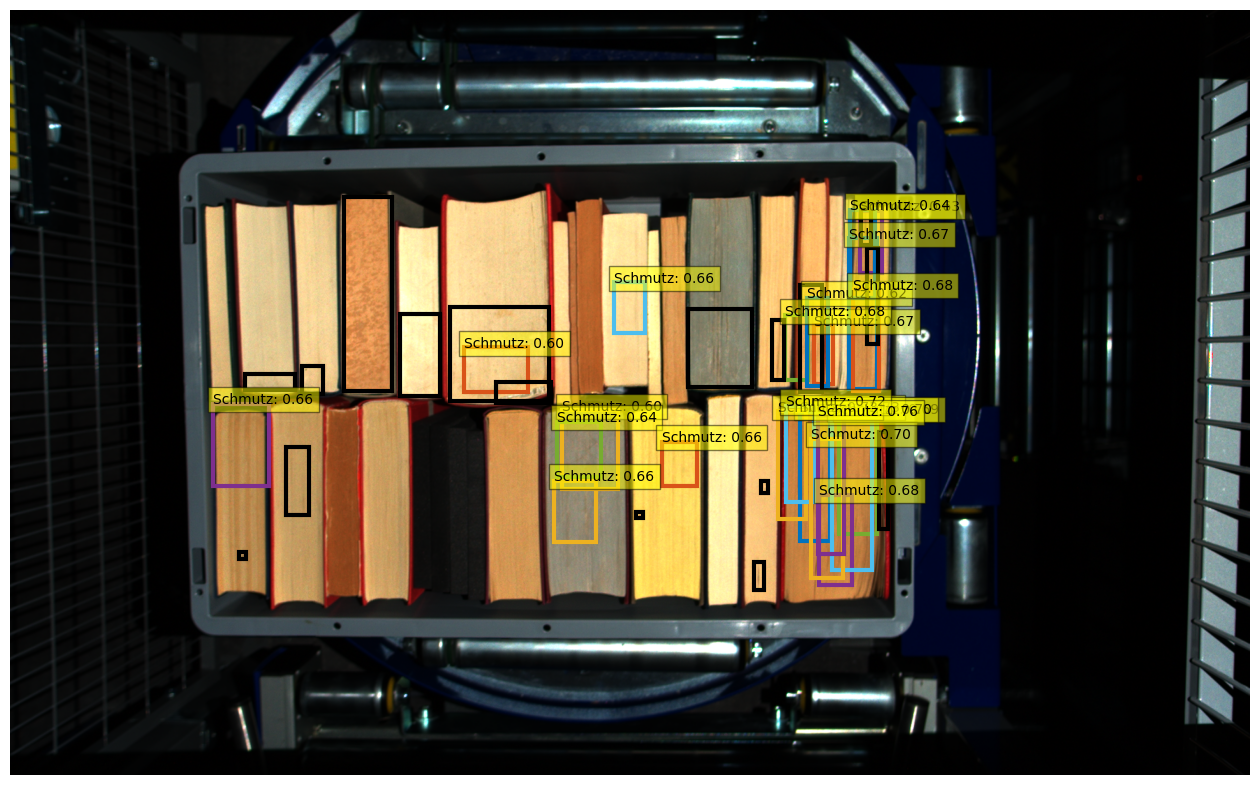

{'scores': tensor([0.6021, 0.6182, 0.6156, 0.6223, 0.7179, 0.6143, 0.6882, 0.6083, 0.6482,
        0.6142, 0.6117, 0.6040, 0.6368, 0.6629], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 316.4851,  652.6062,  347.9435,  696.3094],
        [1319.8698,  390.0858, 1354.1879,  565.0178],
        [1278.7231,  482.7794, 1326.0376,  566.8414],
        [1019.9932,  700.2765, 1073.6755,  857.0613],
        [1324.0658,  631.3005, 1369.8287,  710.5107],
        [1157.8068,  483.4702, 1200.3707,  580.2170],
        [1322.3644,  629.8146, 1370.6765,  712.6169],
        [1040.1969,  699.8508, 1089.5663,  801.8813],
        [ 359.2797,  777.9821,  411.3315,  903.7479],
        [1130.4324,  519.8359, 1176.1560,  580.6685],
        [1282.5084,  325.7156, 1329.2992,  540.8290],
        [ 327.5856,  651.0522,  360.4047,  692.5414],
        [1018.3174,  694.3954, 1064.8629,  806.4489],
        [1273.1946,  630.1089, 1340.5367,  711.2704]

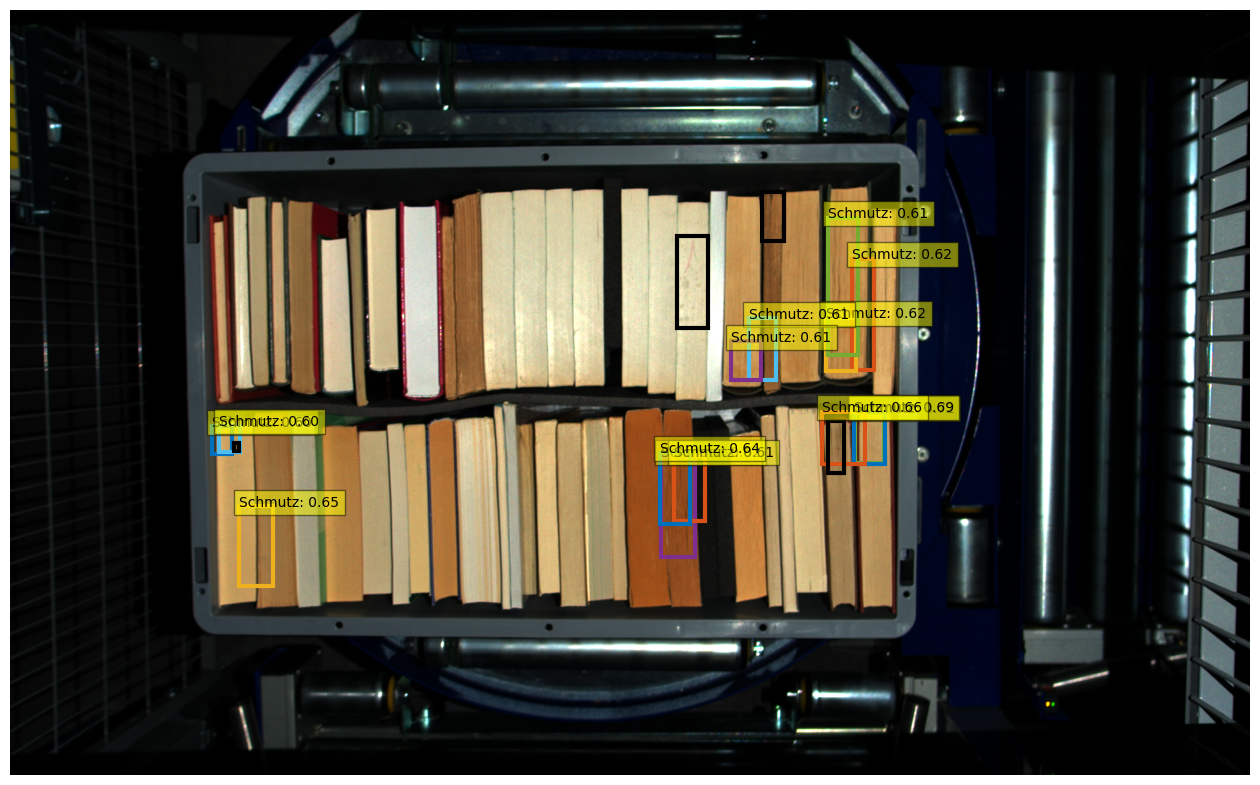

{'scores': tensor([0.6515], device='cuda:0'), 'labels': tensor([6], device='cuda:0'), 'boxes': tensor([[925.2570, 599.8952, 965.2313, 637.7627]], device='cuda:0')}
{'Sonstiges': 1}
{'Schmutz': 6, 'Sonstiges': 4, 'Wasser': 1}


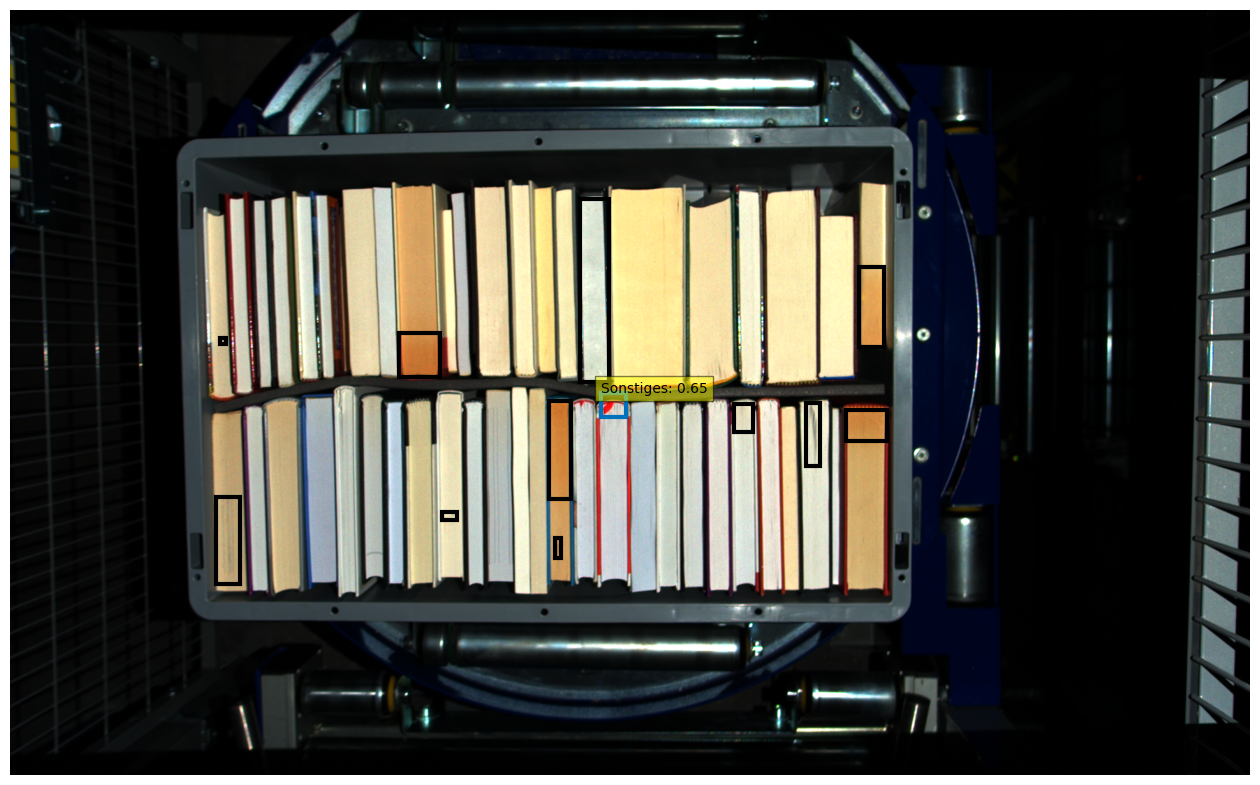

{'scores': tensor([0.6140, 0.6041, 0.6670, 0.6192], device='cuda:0'), 'labels': tensor([3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[1293.8427,  594.9141, 1355.6830,  801.1411],
        [ 722.7618,  612.7896,  789.4832,  681.6674],
        [ 859.9327,  557.5878,  911.7505,  710.5941],
        [1270.0504,  595.0777, 1330.0563,  736.9018]], device='cuda:0')}
{'Schmutz': 4}
{'Schäden': 2, 'Wasser': 1, 'Schmutz': 2}


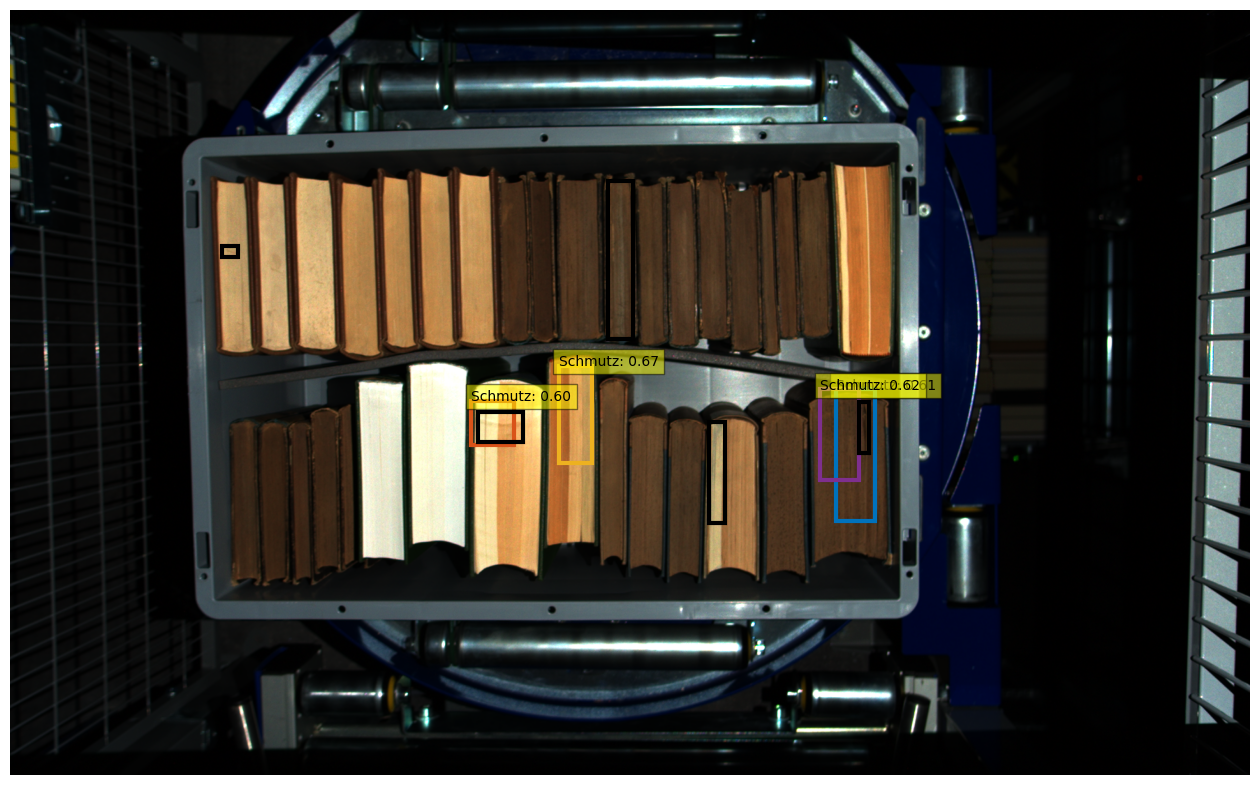

{'scores': tensor([0.6742, 0.6080], device='cuda:0'), 'labels': tensor([3, 3], device='cuda:0'), 'boxes': tensor([[ 954.7473,  613.6833, 1004.5771,  754.3401],
        [ 932.3007,  618.9438,  978.4334,  706.6102]], device='cuda:0')}
{'Schmutz': 2}
{'Sonstiges': 2, 'Schmutz': 6}


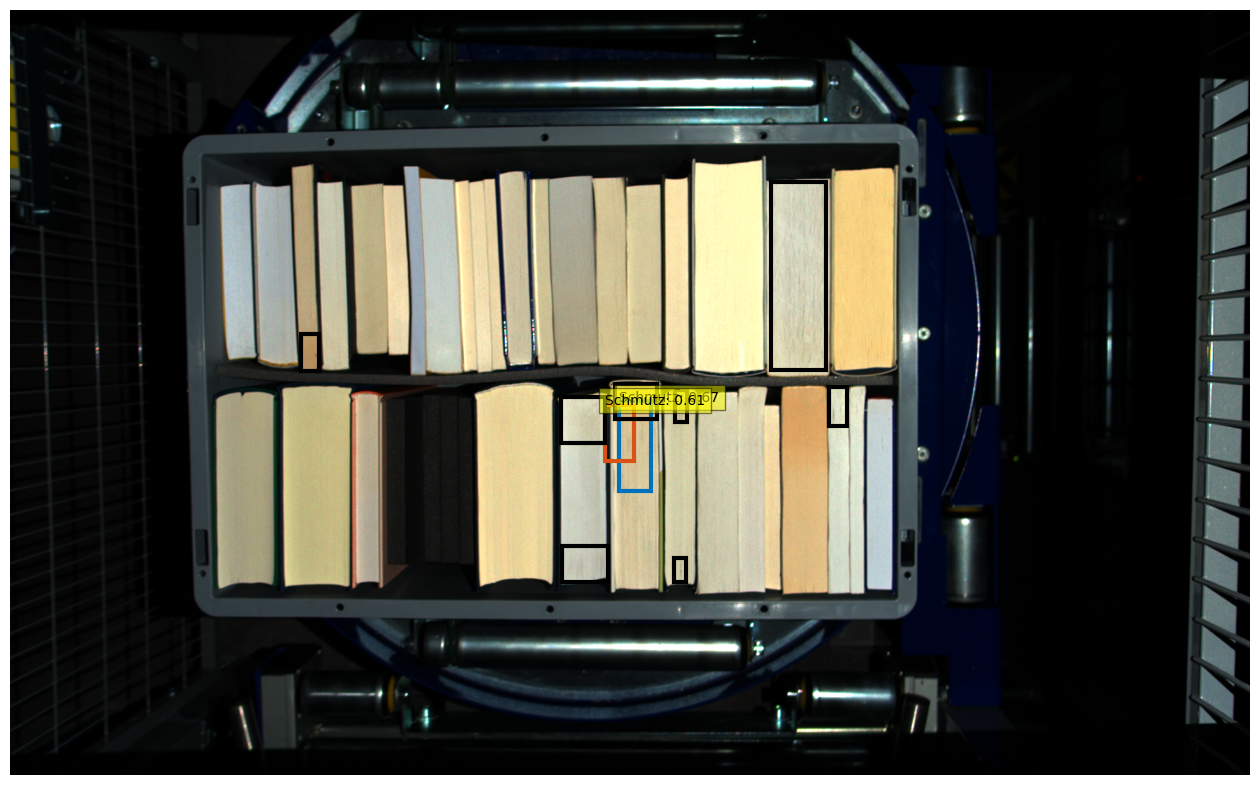

{'scores': tensor([0.6108, 0.6144, 0.6062, 0.7193, 0.6654, 0.6212, 0.6064, 0.7020, 0.6334,
        0.6170, 0.6470, 0.6013, 0.6329], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[464.4617, 536.1338, 581.3120, 555.6476],
        [744.0667, 380.2638, 830.1302, 408.2834],
        [727.6088, 423.8687, 831.1561, 447.3416],
        [570.4810, 713.4581, 646.9796, 747.2842],
        [559.4921, 718.4938, 633.3694, 751.5490],
        [402.5796, 633.9799, 561.5739, 671.6212],
        [609.6594, 499.1565, 822.0937, 535.2342],
        [575.9423, 715.6948, 667.9976, 750.7828],
        [444.7407, 478.5330, 590.3355, 505.2162],
        [352.0384, 748.9675, 457.5929, 786.8399],
        [635.6402, 694.2119, 794.5268, 735.2218],
        [377.0167, 450.1944, 563.3616, 480.7469],
        [400.7197, 537.3679, 575.9198, 562.5526]], device='cuda:0')}
{'Schmutz': 13}
{'Schmutz': 5, 'Schäden': 3}


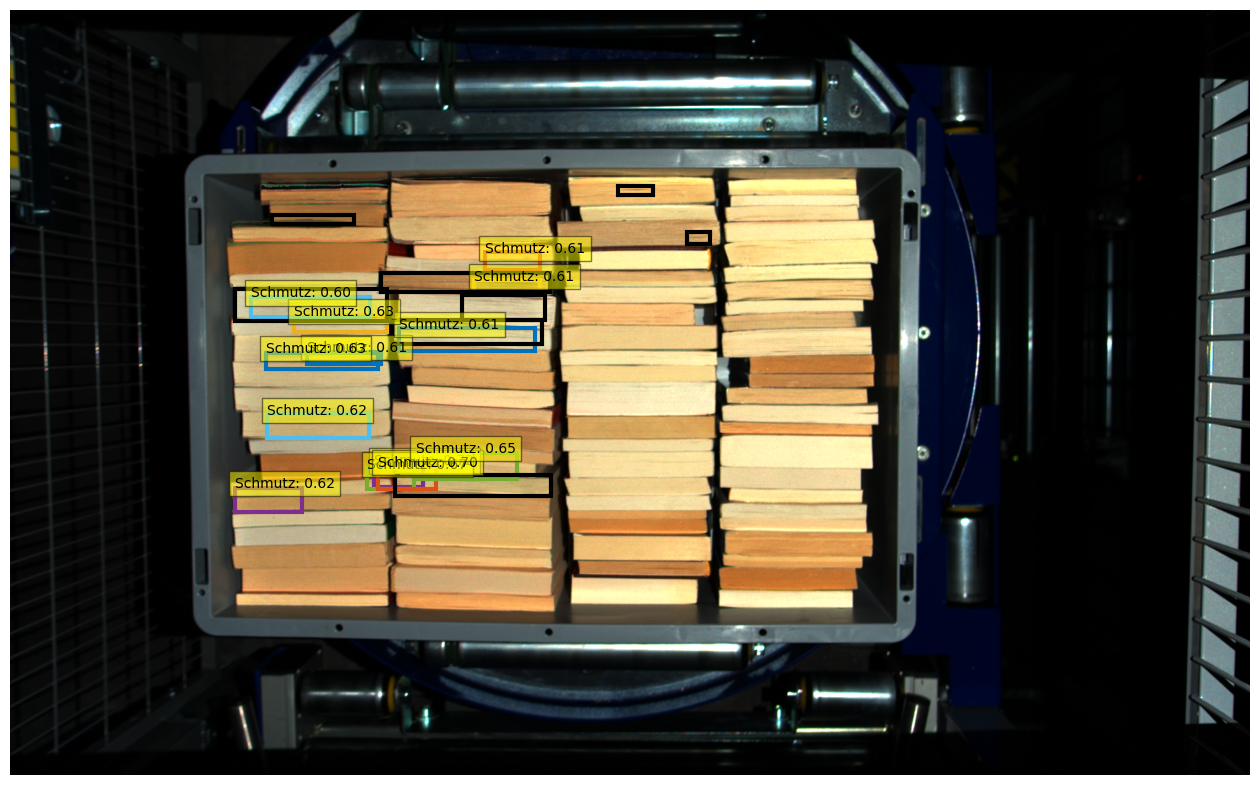

In [19]:
# Visualize
for z in range(6):
    pixel_values, target = val_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    

    annotations = val_dataset.coco.imgToAnns["image_id"]

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values)

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    def plot_results(pil_img, scores, labels, boxes, anno):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        types = {}
        for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            textx = text.split(": ")
            if textx[0] in types:
                types.update({textx[0]: types[textx[0]] + 1})
            else: 
                types.update({textx[0]:1})
            ax.text(xmin, ymin, text, fontsize=10,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        print(types)
        
        # draw annotatet boxes
        typesAnno = {}
        color = [0.000, 0.000, 0.000]
        # TODO Resize bbox
        for annot in anno:
            (x, y, w, h) = annot["bbox"]
            (xmin, ymin, xmax, ymax) = (x, y, x + w, y + h)
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=color, linewidth=3))
            text = f'{id2label[annot["category_id"]]}'
            if text in typesAnno:
                typesAnno.update({text: typesAnno[text] + 1})
            else: 
                typesAnno.update({text:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='black', alpha=0.0))
        print(typesAnno)
        plt.axis('off')
        plt.show()

    # load image based on ID
    image_id = target['image_id'].item()
    image = val_dataset.coco.loadImgs(image_id)[0]
    anno = val_dataset.coco.imgToAnns[image_id]
    image = Image.open(os.path.join('../../../old/BAA/Data/val_max', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = feature_extractor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.6)
    results = postprocessed_outputs[0]
    print(results)
    plot_results(image, results['scores'], results['labels'], results['boxes'], anno)